# HW "Rosbank ML Competition"

Данильченко Вадим

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным валютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИЕ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

In [24]:
# РЕШЕНИЕ ------------------------------------------------------------------------------------------------------------------

# импортируем нужные библиотеки
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

In [25]:
# импортируем данные и посмотрим на первый десяток
df=pd.read_csv('rosbank_train.csv')
df.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.0,POS,0,0.0
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.0,POS,0,0.0
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.0,POS,0,0.0
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.0,POS,0,0.0
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.0,POS,0,0.0


In [26]:
# примерная расшифровка названий атрибутов
# PERIOD - месяц операции в формате 01/MM/YYYY
# MCC- Merchant Category Code — буквально «код категории продавца»
# channel_type - канал привлечения (первое значение для всех транзакций)
# currency - валюта транзакции
# TRDATETIME - дата/время операции
# amount - размер транзакции
# trx_category - тип транзакции
# target_flag - наша разметка, где 0 - не воспользовался услугами, 1 - воспользовался услугами в дальнейшем

# посмотрим статистику
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [27]:
# видим пропуски данных в channel_type
# удалим транзакции с отсутствующим каналом
df.dropna(inplace=True)

# теперь количество данных совпадает
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487603 entries, 2910 to 490512
Data columns (total 10 columns):
PERIOD          487603 non-null object
cl_id           487603 non-null int64
MCC             487603 non-null int64
channel_type    487603 non-null object
currency        487603 non-null int64
TRDATETIME      487603 non-null object
amount          487603 non-null float64
trx_category    487603 non-null object
target_flag     487603 non-null int64
target_sum      487603 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 40.9+ MB


In [28]:
# посмотрим какое количество уникальных значений в наших полях
def count_unique_elements(dataframe):
    dict_result={}
    for col in dataframe.columns:
        dict_result.setdefault(col,0)
        dict_result[col]=len(dataframe[col].unique())

    return dict_result
count_unique_elements(df)

{'PERIOD': 19,
 'cl_id': 4975,
 'MCC': 344,
 'channel_type': 5,
 'currency': 59,
 'TRDATETIME': 57630,
 'amount': 85443,
 'trx_category': 10,
 'target_flag': 2,
 'target_sum': 2640}

In [29]:
# подключимся к списку MCC-категорий и добавим описание
MCC=pd.read_excel('MCC.xlsx')
df=df.merge(MCC, on='MCC',  how='left')

# ПОСМОТРИМ НА САМЫЕ ПОПУЛЯРНЫЕ КАТЕГОРИИ ВНУТРИ АТРИБУТА (найдем ТОП)
# 1. MCC - продуктовые, обналичка и фастфуд составляют 44%
# опытным путем приходим к выводу, что лучше сосредоточиться на топ 10 категориях, обеспечивающих 70% транзакций, остальные 
# имеют совсем малую долю и можно потратить больше денег на их привлечение и удержание, чем они принесут прибыли
MCC_top=df[df.MCC.isin(df.MCC.value_counts(normalize=True).head(10).keys())].groupby(['MCC','DESCRIPTION']).\
    MCC.count().sort_values(ascending=False)/df.MCC.count()
print(MCC_top, '\n\nsumm top 10: {:%}'.format(sum(MCC_top)))

MCC   DESCRIPTION                 
5411   Grocery Stores,supermarkets    0.248144
6011   ATM                            0.110885
5814   Fast Food Res.                 0.084319
5812   Eating Places,Restaurants      0.061302
5499   Miscellaneous Food Stores      0.055527
5541   Service Stations               0.040342
5912   Drug Stores,pharmacies         0.038168
5999   Miscellaneous & specialty r    0.026468
6012   Member Financial Institutio    0.020504
5921   Package Stores - Beer, Liqu    0.017551
Name: MCC, dtype: float64 

summ top 10: 70.321142%


In [30]:
# посмотрим какие из этих продуктовых категорий максимально указывают на дальнейшие покупки клиента в будущем
# для этого посчитаем долю 1 в категории и отсортируем по убыванию показателя
MCC_good=pd.DataFrame(df[df.target_flag==1].MCC.value_counts()/df.MCC.value_counts()).sort_values(by='MCC', ascending=False)
MCC_good.reset_index()

,index,MCC
0,3405,1.000000
1,3512,1.000000
2,3555,1.000000
3,3548,1.000000
4,3543,1.000000
5,3535,1.000000
6,7549,1.000000
7,3513,1.000000
8,7534,1.000000
9,3583,1.000000


In [31]:
# в списке есть категории без единиц, то есть можно сказать, что покупки в данных категориях не имеют предсказательной силы
print('количество null-категорий: {}'.format(MCC_good.isna().sum()[0]))
# выбросим категории без единиц и посмотрим на статистику
MCC_good.dropna().describe()

количество null-категорий: 25


,MCC
count,319.000000
mean,0.710871
std,0.208019
min,0.034483
25%,0.598921
50%,0.708595
75%,0.866667
max,1.000000


In [32]:
print('из 319 кодов мерчанта как минимум в половине случаев 70% единиц по таргету, \
а количество категорий состоящих только из 1: {}'.format(MCC_good[MCC_good.MCC==1].count()[0]))
# проверим долю единичек в топ3 категории
MCC_top=pd.DataFrame(MCC_top)
MCC_top.rename(columns={'MCC':'MCC_count'}, inplace=True)
MCC_top=MCC_top.reset_index()
MCC_good.MCC[MCC_top.MCC].reset_index()

из 319 кодов мерчанта как минимум в половине случаев 70% единиц по таргету, а количество категорий состоящих только из 1: 59


,index,MCC
0,5411,0.620169
1,6011,0.654972
2,5814,0.733570
3,5812,0.725737
4,5499,0.658246
5,5541,0.639317
6,5912,0.640105
7,5999,0.709283
8,6012,0.567313
9,5921,0.673756


In [33]:
# на мой взгляд довольно неплохо - эти типы имеют максимальную долю среди транзакций и при этом содержат минимум 56% единичек
# (при этом это небольшая доля транзакций - 2%), основная же масса в топ 10 от 62% до 73%
# это значит, что минимум 62% клиентов, совершивших подобные покупки, вернулись в будущем
# надо проверить на распеределение данных категорий по дате, чтобы исключить гипотезу, что в следствие какой-то временной акции
# все эти транзакции сосредоточены вокруг одного периода

# импортируем библиотеки и создадим обертку для графика - далее будем передавать в нее сводную таблицу
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

def plotly_line_plot(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [34]:
# напишем функцию для преобразования периода в корректный для сортировки в сводной таблице формат
from datetime import datetime
def change_date(date):
    curr_date=datetime.strptime(date, '%d/%m/%Y')
    return curr_date.strftime('%Y-%m-%d')

# сделаем преобразование датафрейма - заменим столбцец с исходной датой на более подходящий для последующей сортировки
# сгруппируем все значения по периодам и категориям мерчанта
period_count=df[df.MCC.isin(MCC_top.MCC)].groupby(['PERIOD','DESCRIPTION']).cl_id.count().reset_index().rename(columns={'cl_id':'count'})
period_count['PERIOD_NEW']=period_count.PERIOD.apply(change_date)
period_count=period_count[period_count.columns[1:]]

# создадим сводную таблицу, где по столбцам разложим категории
period_count_pivot=period_count.pivot_table(
                        index='PERIOD_NEW', 
                        columns='DESCRIPTION', 
                        values='count', 
                        aggfunc=sum).fillna(0).applymap(float)

# передадим таблицу в обертку графика
plotly_line_plot(period_count_pivot, 'распределение продаж топ10 категорий по периодам')

In [35]:
# видим, что продажи топ 10 категорий не сосредоточены вокруг одной даты, а распределены по периоду с некоторой закономерностью
# мы можем наблюдать 2 моды - декабрь 2016 и июль 2017, учитыая специфику топ 3 категорий, зимой это закупки к праздничному столу, 
# снятие наличных для покупки подарков и соответствующее питание на фудкортах во время прогулок по торговм центрам за едой 
# и подарками
# летом же закупки продуктов для отдыха на природе/даче, снятие наличных для оплаты путешествий, долгие прогулки на 
# свежем воздухе, которые неизбежно приведут к перекусам в фастфудах

# интерес вызывает спад востребованности этих категорий со второй половины 2017го года, возможно это связано, например, 
# с изменением категорий повышенного кэшбэка для клиентов и оттока денег в другие MCC, которые не успели сделать заметной долю на 
# полном периоде - надо посмотреть на продажи других продуктовых категорий в периоде 08.17-04.18 

period_test=df
period_test['PERIOD_NEW']=period_test.PERIOD.apply(change_date)
period_test=period_test[period_test.PERIOD_NEW>='2017-08-01']
MCC_top2=(period_test.groupby(['MCC','DESCRIPTION']).MCC.count().sort_values(ascending=False)/period_test.MCC.count()).head(10)
print(MCC_top2, '\n\nsumm top 10: {:%}'.format(sum(MCC_top2)))

MCC   DESCRIPTION                 
5411   Grocery Stores,supermarkets    0.225567
6011   ATM                            0.113588
5814   Fast Food Res.                 0.100785
5812   Eating Places,Restaurants      0.070789
5499   Miscellaneous Food Stores      0.058209
5541   Service Stations               0.039329
5912   Drug Stores,pharmacies         0.035811
6012   Member Financial Institutio    0.031508
5999   Miscellaneous & specialty r    0.027079
5921   Package Stores - Beer, Liqu    0.017872
Name: MCC, dtype: float64 

summ top 10: 72.053693%


In [36]:
# видим, что состав первых 10 категорий не изменился, хотя доля подросла до 72%, значит количество транзакций банка снизилось

# 2. проведем анализ канала привлечения клиента - их 5, посмотрим какой канал приносит больше постоянных клиентов
# каналы 1 и 2 принесли больше всего транзакций (97%)
CHANEL_top=df.channel_type.value_counts()/df.channel_type.count()
print(CHANEL_top, '\n\nsumm top 2: {:%}'.format(sum(CHANEL_top.head(2))))

type1    0.613710
type2    0.358925
type5    0.011458
type4    0.009180
type3    0.006727
Name: channel_type, dtype: float64 

summ top 2: 97.263553%


In [37]:
# посмотрим сколько клиентов в дальнейшем воспользовались услугами банка
df[df.target_flag==1].channel_type.value_counts()/df.channel_type.value_counts()
# проверим распределение каналов в топ10 продуктовых категорий транзакций
#MCC_top2=(period_test.groupby(['MCC','DESCRIPTION']).MCC.count().sort_values(ascending=False)/period_test.MCC.count()).head(10)
df[df.MCC.isin(MCC_top2.rename(columns={'MCC':'share'}).reset_index().MCC)].channel_type.value_counts()\
    /df[df.MCC.isin(MCC_top2.rename(columns={'MCC':'share'}).reset_index().MCC)].channel_type.count()

type1    0.605244
type2    0.367342
type5    0.011998
type4    0.008685
type3    0.006731
Name: channel_type, dtype: float64

In [38]:
# расределение сохраняется
# посмотрим сколько клиентов в дальнейшем воспользовались услугами банка
df[df.target_flag==1].channel_type.value_counts()/df.channel_type.value_counts()

type1    0.512847
type2    0.887340
type3    0.689939
type4    0.770777
type5    0.777340
Name: channel_type, dtype: float64

In [39]:
# оказывается хоть и канал 2 принес всего 36% клиентов, в будущем 89% из них возвращаются, а значение первого канала 
# немногим больше результата случайного гадания. На данном этапе оставим первые два

# 3. изучим тип транзакции (trx_category)
df.trx_category.value_counts()/df.trx_category.count()

POS               0.848930
DEPOSIT           0.043220
WD_ATM_ROS        0.038925
WD_ATM_PARTNER    0.020330
C2C_IN            0.014897
WD_ATM_OTHER      0.014600
C2C_OUT           0.011089
BACK_TRX          0.005502
CAT               0.002436
CASH_ADV          0.000070
Name: trx_category, dtype: float64

In [40]:
# POS (думаю, POS-терминал, используемый в торговых точках) составляет 84% от всех транзакций
# посмотрим на долю целевой переменной

df[df.target_flag==1].trx_category.value_counts()/df.trx_category.value_counts()

BACK_TRX          0.589638
C2C_IN            0.541713
C2C_OUT           0.674681
CASH_ADV          0.529412
CAT               0.752525
DEPOSIT           0.468255
POS               0.656823
WD_ATM_OTHER      0.891839
WD_ATM_PARTNER    0.714113
WD_ATM_ROS        0.714489
Name: trx_category, dtype: float64

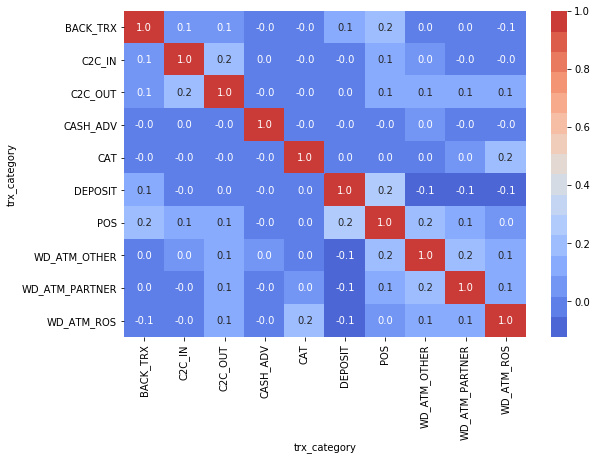

In [50]:
# 65% клиентов из POS вернулись в банк, можно дальше рассматривать только этот тип
# интересно посмотреть есть ли зависимость между транзакциями клиентов, скажем, кто воспользовался POS, использует также и 
# WD_ATM_ROS (думаю, снятие наличных в банкоматах Росбанка)

cl_trx_count=df.groupby(['cl_id','trx_category']).agg({'trx_category': 'count'})
cl_trx_count=cl_trx_count.rename(columns={'trx_category':'count'}).reset_index()
data_for_corr=cl_trx_count.pivot_table(
                        index='cl_id',
                        columns='trx_category',
                        values='count',
                        aggfunc=sum).fillna(0)
#data_for_corr.corr()
# визуализируем результаты
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(data_for_corr.corr(), annot=True, fmt='.1f', ax=ax, cmap=sns.color_palette('coolwarm', 16))

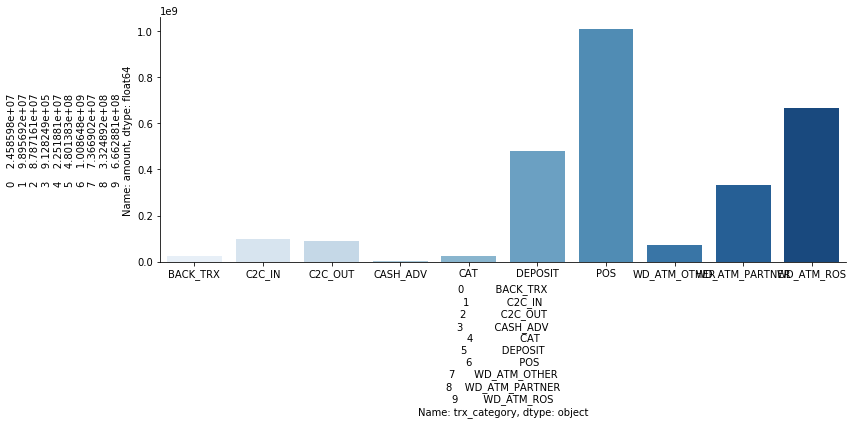

In [44]:
# максимальная корреляция 0.2 - линейная зависимость между наличием разных типов транзакций у клиента не обнаружена
# теперь оценим объемы транзаций, чтобы смело отбросить транзакции с малой долей в общем числе

trx_sum=df.groupby(['trx_category']).agg({'amount':'sum'})
trx_sum=trx_sum.reset_index()
sns.catplot(trx_sum.trx_category,trx_sum.amount, data=trx_sum, kind="bar", palette="Blues", height=6,aspect=2)

In [45]:
# больше всего по сумме POS, интересно, что снятие денег (в банкоматах Росбанка, партнеров и других) по объему больше POS
trx_sum_share=(trx_sum.amount.sort_values(ascending=False)/trx_sum.amount.sum()).reset_index().rename(columns={'index':'number'})
f'сумма по снятиям наличных в банкоматах(банк, пратнеры, другие): \
{trx_sum_share[trx_sum_share.number.isin([7,8,9])].amount.sum():%}, POS же: \
{trx_sum_share[trx_sum_share.number==6].amount[0]:%}%'

'сумма по снятиям наличных в банкоматах(банк, пратнеры, другие): 38.355367%, POS же: 36.073666%%'

In [46]:
# думаю, стоит объединить снятия наличных в одну группу и посмотреть статистику заново
# функция объединит эти три канала в один
def trx_new(channel):
    if channel=='WD_ATM_OTHER' or channel=='WD_ATM_PARTNER' or channel=='WD_ATM_ROS':
        return 'WD_ATM'
    else:
        return channel

# создам новое поле с объединенным типом транзакций и посмотрю на долю
df['trx_category_new']=df.trx_category.apply(trx_new)
df.trx_category_new.value_counts()/df.trx_category_new.count()

POS         0.848930
WD_ATM      0.073855
DEPOSIT     0.043220
C2C_IN      0.014897
C2C_OUT     0.011089
BACK_TRX    0.005502
CAT         0.002436
CASH_ADV    0.000070
Name: trx_category_new, dtype: float64

In [47]:
# доля количества объединенных транзакций по снятию наличных 7%, посмотрим на долю в ней единиц целевой переменной
df[df.target_flag==1].trx_category_new.value_counts()/df.trx_category_new.value_counts()

POS         0.656823
WD_ATM      0.749445
DEPOSIT     0.468255
C2C_IN      0.541713
C2C_OUT     0.674681
BACK_TRX    0.589638
CAT         0.752525
CASH_ADV    0.529412
Name: trx_category_new, dtype: float64

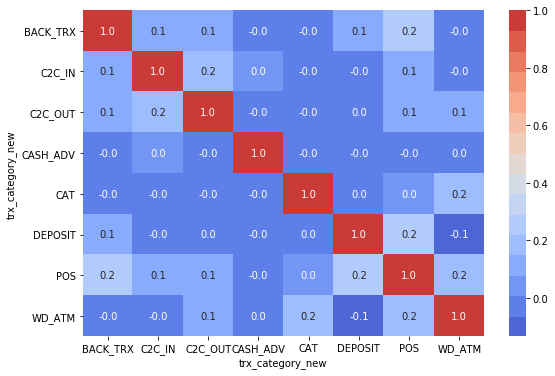

In [51]:
# 75% клиентов, использующих банкоматы, впоследствии вернулось, добавляем этот тип в список атрибутов для дальнешего анализа
# есть еще один тип транзакций - депозиты, 3 место по сумме, но количество единиц целевой переменной 47%, что плохо, 
# с другой стороны этот тоже информативно - можно считать, что качество этой услуги недостаточно и клиент, воспользовавшись ей, 
# с большей вероятностью откажется сотрудничать с банком в дальнейшем, то есть это зона роста для банка

# снова посмотрим на корреляцию
cl_trx_count=df.groupby(['cl_id','trx_category_new']).agg({'trx_category_new': 'count'})
cl_trx_count=cl_trx_count.rename(columns={'trx_category_new':'count'}).reset_index()
data_for_corr=cl_trx_count.pivot_table(
                        index='cl_id',
                        columns='trx_category_new',
                        values='count',
                        aggfunc=sum).fillna(0)   
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_for_corr.corr(), annot=True, fmt='.1f', ax=ax, cmap=sns.color_palette('coolwarm', 16))

In [52]:
# даа, лучше не стало :)) идем дальше
# 4. валюта транзакции
(df.currency.value_counts()/df.currency.count()).head()

810    0.973743
978    0.011261
840    0.003940
933    0.001151
985    0.000859
Name: currency, dtype: float64

In [53]:
# 97% всех транзакций составляет валюта с кодом 810 (код рубля), проверим на долю этой валюты типе транзакции, 
# чтобы убедиться в коррекности сопоставления сумм 

df[df.currency==810].trx_category_new.value_counts()/df.trx_category_new.value_counts()

POS         0.971264
WD_ATM      0.980812
DEPOSIT     0.999858
C2C_IN      0.995732
C2C_OUT     1.000000
BACK_TRX    0.938502
CAT         1.000000
CASH_ADV    0.470588
Name: trx_category_new, dtype: float64

In [54]:
# доля рубля в самых массовых типах транзакций 97-98%, можно работать дальше только с рублем

# 5. посмотрим на распределение транзакций по дням недели
#last_monday=(datetime.today()-timedelta(days=datetime.today().weekday())).strftime("%Y-%m-%d")
df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,DESCRIPTION,PERIOD_NEW,trx_category_new
0,01/07/2017,50,4829,type5,810,14JUL17:06:53:13,40000.0,C2C_IN,1,74592.37,Wire Transfer Money Orders,2017-07-01,C2C_IN
1,01/09/2017,50,5411,type5,810,15SEP17:00:00:00,2373.0,POS,1,74592.37,"Grocery Stores,supermarkets",2017-09-01,POS
2,01/09/2017,50,5812,type5,810,24SEP17:00:00:00,5955.0,POS,1,74592.37,"Eating Places,Restaurants",2017-09-01,POS
3,01/07/2017,50,5661,type5,810,08JUL17:00:00:00,5599.0,POS,1,74592.37,Shoe stores,2017-07-01,POS
4,01/07/2017,50,5732,type5,810,08JUL17:00:00:00,29600.0,POS,1,74592.37,Electronic Sales,2017-07-01,POS


In [55]:
# напишем функцию, преобразующую дату в день недели
def wkday(date):
    return datetime.strptime(date, '%Y-%m-%d').weekday()+1
# добавим новое поле в исходный фрейм данных
df['weekday']=df.PERIOD_NEW.apply(wkday)

,weekday_names,cnt_transactions
0,4,0.214135
1,6,0.208604
2,3,0.158426
3,2,0.136749
4,7,0.113734
5,1,0.101636
6,5,0.066716


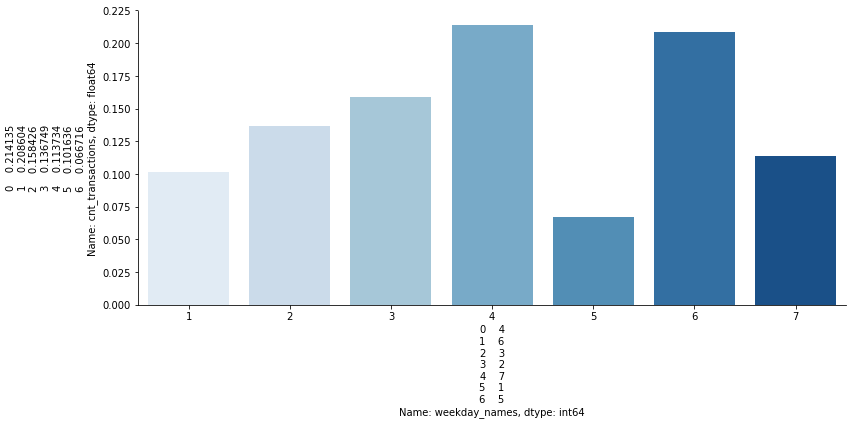

In [56]:
# выведем распределение транзакций по дням недели
weekdays=(df['weekday'].value_counts()/df['weekday'].count()).reset_index()
weekdays=weekdays.rename(columns={'weekday':'cnt_transactions','index':'weekday_names'})
sns.catplot(weekdays.weekday_names,weekdays.cnt_transactions, data=weekdays, kind="bar", palette="Blues", height=6, aspect=2)
weekdays

In [57]:
# меньше всего транзакций совершается в пятницу (10%), больше всего в четверг и субботу (по 21%)
# посмотрим долю единичек целевой переменной 
weekdays_targ=(df[df.target_flag==1]['weekday'].value_counts()/df['weekday'].value_counts()).reset_index()
weekdays_targ=weekdays_targ.rename(columns={'weekday':'cnt_transactions','index':'weekday_names'})
weekdays_targ

,weekday_names,cnt_transactions
0,1,0.661649
1,2,0.664062
2,3,0.651633
3,4,0.612721
4,5,0.794473
5,6,0.664006
6,7,0.614025


,weekday,amount
0,1,0.101060
1,2,0.137108
2,3,0.165526
3,4,0.224387
4,5,0.060092
5,6,0.209180
6,7,0.102648


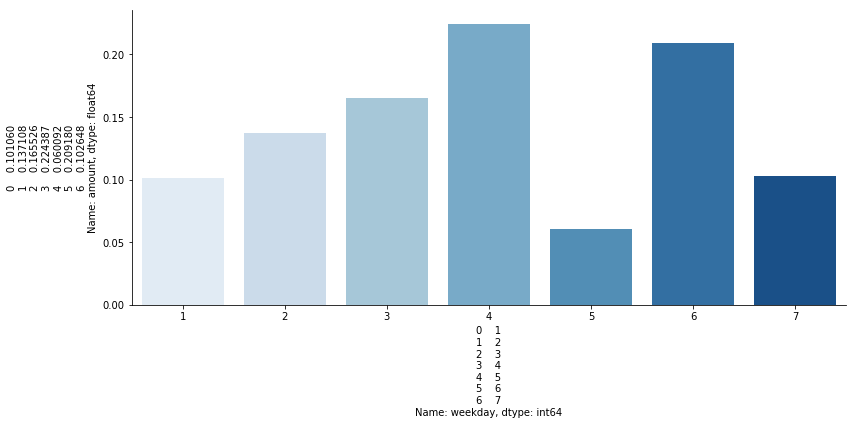

In [58]:
# интересно, что клиенты с транзакциями по пятницам возвращаются чаще остальных (79% от пятницы), посмотрим на объем

weekdays_sum=(df[df.currency==810].groupby(['weekday']).amount.sum()/df[df.currency==810].amount.sum()).reset_index()
sns.catplot(weekdays_sum.weekday,weekdays_sum.amount, data=weekdays_sum, kind="bar", palette="Blues", height=6, aspect=2)
weekdays_sum

In [59]:
# сумма по дням не отличается от количества транзакций

# подведем краткие итоги:
# 1. MCC - топ 10 категорий мерчанта 
MCC_list=MCC_top.MCC.tolist()
print('1. топ 10 категорий мерчанта составляет {:%} от всех \nСписок категорий: {}'.format(sum(MCC_top2),MCC_list))
# 2. channel_type - ТОП 2 канала 
channel_distr=(df.channel_type.value_counts()/df.channel_type.count()).reset_index().rename(columns={'index':'channel'})
channel=channel_distr.head(2).channel.tolist()
channel_share=channel_distr[channel_distr.channel.isin(channel)].channel_type.sum()/channel_distr.channel_type.sum()
print('2. 2 канала привлечения {:%} от всех \nСписок каналов: {}'.format(channel_share, channel))
# 3. trx_category - оставляем POS и WD_ATM
trx_distr=(df.trx_category_new.value_counts()/df.trx_category_new.count()).reset_index().rename(columns={'index':'channel'})
trx=trx_distr.head(2).channel.tolist()
trs_share=trx_distr[trx_distr.channel.isin(trx)].trx_category_new.sum()/trx_distr.trx_category_new.sum()
print('3. 2 канала последующих расходов {:%} от всех \nСписок каналов: {}'.format(trs_share, trx))
# 4. currency - оставляем RUR (df.currency.value_counts()/df.currency.count()).head()
currency_distr=(df.currency.value_counts()/df.currency.count()).reset_index().rename(columns={'index':'currency_name'})
currency=currency_distr.head(1).currency_name.tolist()
currency_share=currency_distr[currency_distr.currency_name.isin(currency)].currency.sum()/currency_distr.currency.sum()
print('4. 1 валюта транзакций {:%} от всех \nКод валюты: {}'.format(currency_share, currency))
# 5. день недели - оставляем все
print('5. оставляем все дни недели')

1. топ 10 категорий мерчанта составляет 72.053693% от всех 
Список категорий: [5411, 6011, 5814, 5812, 5499, 5541, 5912, 5999, 6012, 5921]
2. 2 канала привлечения 97.263553% от всех 
Список каналов: ['type1', 'type2']
3. 2 канала последующих расходов 92.278554% от всех 
Список каналов: ['POS', 'WD_ATM']
4. 1 валюта транзакций 97.374298% от всех 
Код валюты: [810]
5. оставляем все дни недели


In [60]:
# приведем данные в пригодный для модели вид - фичи по столбцам, cl_id по строкам
df_model=df[(df.MCC.isin(MCC_list))&(df.channel_type.isin(channel))&(df.trx_category_new.isin(trx))&(df.currency==currency)]\
    [['cl_id','channel_type', 'MCC', 'trx_category_new','weekday']]


In [61]:
df_model_agg=df_model.groupby(['cl_id','channel_type', 'MCC', 'trx_category_new','weekday']).agg({'cl_id':'count'})
df_model_agg=df_model_agg.rename(columns={'cl_id':'trx_count'})
#df_model_agg
df_model_agg.unstack(level=[1,2,3,4]).reset_index()

cl_id trx_count                                          \
channel_type                type2                                           
MCC                          5411             5541       5812        5814   
trx_category_new              POS              POS        POS         POS   
weekday                         3     6     7    3    6     3     6     3   
0                   269      30.0  15.0   3.0  2.0  1.0   2.0   7.0  35.0   
1                   272       NaN   4.0   NaN  NaN  2.0   NaN   NaN   NaN   
2                   273       NaN  11.0   NaN  NaN  NaN   NaN   2.0   NaN   
3                   274       NaN  10.0   2.0  NaN  5.0   NaN   3.0   NaN   
4                   277       NaN   5.0   NaN  NaN  NaN   NaN   4.0   NaN   
5                   278       NaN  11.0   NaN  NaN  1.0   NaN   1.0   NaN   
6                   279       NaN   NaN  21.0  NaN  NaN   NaN   NaN   NaN   
7                   281      13.0   9.0   NaN  1.0  NaN   NaN   3.0   2.0   
8                   285       NaN   1.0   2.0  NaN  NaN   NaN   2.0   NaN   
9                   294       NaN   7.0   NaN  NaN  NaN   NaN   4.0   NaN   
10                  295       NaN   5.0   NaN  NaN  NaN   NaN  16.0   NaN   
11                  296       NaN   2.0   NaN  NaN  NaN   NaN   2.0   NaN   
12                  297       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
13                  299       7.0   1.0   NaN  1.0  NaN   4.0  13.0   3.0   
14                  300       6.0   NaN   2.0  NaN  NaN   NaN   NaN   NaN   
15                  301       4.0   NaN   6.0  NaN  NaN   2.0   NaN   1.0   
16                  302       NaN  21.0   NaN  NaN  2.0   NaN   NaN   NaN   
17                  304       NaN  10.0   NaN  NaN  NaN   NaN   3.0   NaN   
18                  305      43.0   1.0  22.0  5.0  1.0   2.0   NaN   4.0   
19                  307       NaN   3.0   NaN  NaN  NaN   NaN   2.0   NaN   
20                  308       4.0   1.0   1.0  NaN  NaN  35.0   8.0  25.0   
21                  310      18.0  21.0   NaN  1.0  NaN   NaN   NaN   NaN   
22                  312       NaN   NaN  13.0  NaN  NaN   NaN   NaN   NaN   
23                  314       NaN   6.0   NaN  NaN  5.0   NaN   NaN   NaN   
24                  315       NaN   6.0  23.0  NaN  1.0   NaN   NaN   NaN   
25                  322       NaN   NaN   NaN  NaN  1.0   NaN   7.0   NaN   
26                  325       NaN   7.0   NaN  NaN  NaN   NaN   3.0   NaN   
27                  328      30.0  23.0   NaN  9.0  4.0   4.0   2.0   5.0   
28                  329       NaN   3.0   NaN  NaN  3.0   NaN   1.0   NaN   
29                  331      49.0  24.0   NaN  2.0  4.0  33.0  18.0   7.0   
...                 ...       ...   ...   ...  ...  ...   ...   ...   ...   
4638              10161       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4639              10162       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4640              10163       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4641              10164       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4642              10166       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4643              10167       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4644              10168       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4645              10169       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4646              10170       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4647              10171       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4648              10175       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4649              10176       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4650              10177       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4651              10180       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4652              10181       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4653              10184       NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
4654          

In [62]:
df_model.head()

,cl_id,channel_type,MCC,trx_category_new,weekday
10063,269,type2,5411,POS,3
10066,272,type2,5541,POS,4
10067,272,type2,6011,WD_ATM,6
10068,269,type2,5814,POS,3
10069,269,type2,5411,POS,3


In [63]:
# напишем функцию для преобразования всех уникальных переменных в столбцах исходных данных из строк по столбцам

# функция получает cl_id и какой-то столбец, группирует и делает сводную таблицу, располагая строки столбца по столбцам 
def pvt_table(two_cols_df):
    agg_vals=two_cols_df.groupby(['cl_id',two_cols_df.columns[1]]).agg({'cl_id':'count'}).rename(columns={'cl_id':'cnt_trx'})\
        .reset_index()
    pvt_new=agg_vals.pivot_table(
                        index='cl_id',
                        columns=two_cols_df.columns[1],
                        values='cnt_trx',
                        aggfunc='sum')
    return pvt_new

# вызовем функцию столько раз, сколько есть свободных столбцов, передавая каждый раз cl_id и новый столбец, затем все объединим
# на выходе получим все наши фичи по столбцам и уникальные записи клиентов по строкам, а мерой будет количество транзакций
for i in range(len(df_model.columns)-1):
    if i==0:
        pvt_final=pvt_table(df_model[['cl_id',df_model.columns[i+1]]])
    else:
        pvt_final=pvt_final.merge(pvt_table(df_model[['cl_id',df_model.columns[i+1]]]), on='cl_id', how='left')
        
pvt_final

,type1,type2,5411,5499,5541,5812,5814,5912,5921,5999,...,6012,POS,WD_ATM,1,2,3,4,5,6,7
cl_id,,,,,,,,,,,,,,,,,,,,,
269,NaN,130.0,48.0,NaN,3.0,9.0,54.0,7.0,NaN,9.0,...,NaN,130.0,NaN,NaN,NaN,82.0,NaN,NaN,43.0,5.0
272,NaN,94.0,15.0,44.0,6.0,NaN,1.0,NaN,9.0,1.0,...,NaN,76.0,18.0,NaN,13.0,NaN,22.0,11.0,48.0,NaN
273,NaN,132.0,64.0,NaN,NaN,4.0,58.0,4.0,NaN,2.0,...,NaN,132.0,NaN,NaN,47.0,NaN,32.0,17.0,36.0,NaN
274,NaN,124.0,25.0,63.0,13.0,6.0,3.0,7.0,6.0,1.0,...,NaN,124.0,NaN,NaN,23.0,NaN,NaN,51.0,44.0,6.0
277,NaN,21.0,11.0,NaN,NaN,7.0,NaN,1.0,NaN,NaN,...,NaN,19.0,2.0,2.0,NaN,NaN,7.0,NaN,12.0,NaN
278,NaN,100.0,34.0,2.0,5.0,3.0,50.0,4.0,NaN,2.0,...,NaN,100.0,NaN,NaN,34.0,NaN,34.0,1.0,31.0,NaN
279,NaN,99.0,58.0,2.0,1.0,8.0,7.0,7.0,7.0,9.0,...,NaN,99.0,NaN,NaN,20.0,NaN,NaN,47.0,NaN,32.0
281,NaN,111.0,29.0,52.0,1.0,5.0,8.0,5.0,3.0,3.0,...,NaN,106.0,5.0,31.0,NaN,45.0,2.0,NaN,33.0,NaN
285,NaN,15.0,8.0,NaN,NaN,2.0,1.0,1.0,NaN,3.0,...,NaN,15.0,NaN,NaN,5.0,NaN,NaN,3.0,5.0,2.0


In [64]:
# проверим,что на одного клиента есть отметка 1 или 0 в target_flag, просто для каждой транзакции она повторяется
agg_target=df.groupby(['cl_id', 'target_flag']).agg({'PERIOD':'count'}).reset_index().rename(columns={'PERIOD':'cnt'})
pvt_target=agg_target.pivot_table(
                        index='cl_id',
                        columns='target_flag',
                        values='cnt',
                        aggfunc='sum')
pvt_target.head()

target_flag,0,1
cl_id,,
50,NaN,47.0
52,19.0,NaN
54,167.0,NaN
55,120.0,NaN
56,NaN,40.0


In [65]:
# убедились, теперь можно подтянуть к каждому клиенту его флаг
def unify_target(row):
    if row[1]>0:
        return 1
    else:
        return 0
pvt_target['target_unique']=pvt_target.apply(unify_target, axis=1)
pvt_target=pvt_target[pvt_target.columns[2]].reset_index()

pvt_final=pvt_final.merge(pvt_target, on='cl_id', how='left')
pvt_final.head()

,cl_id,type1,type2,5411,5499,5541,5812,5814,5912,5921,...,POS,WD_ATM,1,2,3,4,5,6,7,target_unique
0,269,NaN,130.0,48.0,NaN,3.0,9.0,54.0,7.0,NaN,...,130.0,NaN,NaN,NaN,82.0,NaN,NaN,43.0,5.0,1
1,272,NaN,94.0,15.0,44.0,6.0,NaN,1.0,NaN,9.0,...,76.0,18.0,NaN,13.0,NaN,22.0,11.0,48.0,NaN,1
2,273,NaN,132.0,64.0,NaN,NaN,4.0,58.0,4.0,NaN,...,132.0,NaN,NaN,47.0,NaN,32.0,17.0,36.0,NaN,1
3,274,NaN,124.0,25.0,63.0,13.0,6.0,3.0,7.0,6.0,...,124.0,NaN,NaN,23.0,NaN,NaN,51.0,44.0,6.0,1
4,277,NaN,21.0,11.0,NaN,NaN,7.0,NaN,1.0,NaN,...,19.0,2.0,2.0,NaN,NaN,7.0,NaN,12.0,NaN,1


In [66]:
# разобьем наши данные на тренировочную и тестовую выборку
from sklearn.cross_validation import train_test_split
y = pvt_final['target_unique'].copy()
data_train, data_test, y_train, y_test = train_test_split(pvt_final, y, test_size=0.3, random_state=42)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [67]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[str(col) + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[str(col) + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [68]:
# build counts
#columns_to_get_counts
columns_to_get_counts=list(pvt_final.columns[:-1])
    
for col_get_prob in columns_to_get_counts:
    data_train, data_test = get_woe_v1(data_train, data_test, col_get_prob, 'target_unique')
    #print(col_get_prob)

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [71]:
# обучим модель c помощью метода градиентоного бустинга
x_train = data_train[columns_to_get_counts]
y_train = data_train['target_unique']
x_test = data_test[columns_to_get_counts]
y_test = data_test['target_unique']

xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.97
Test:  0.83


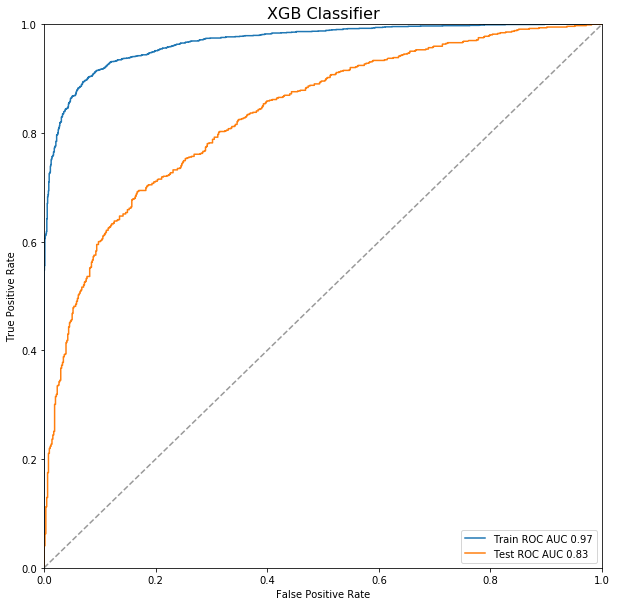

In [73]:
# на тестовых данных показатель прогностической силы классификатора хуже, но не сильно, 
# визуализируем построим график ROC AUC кривой

import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

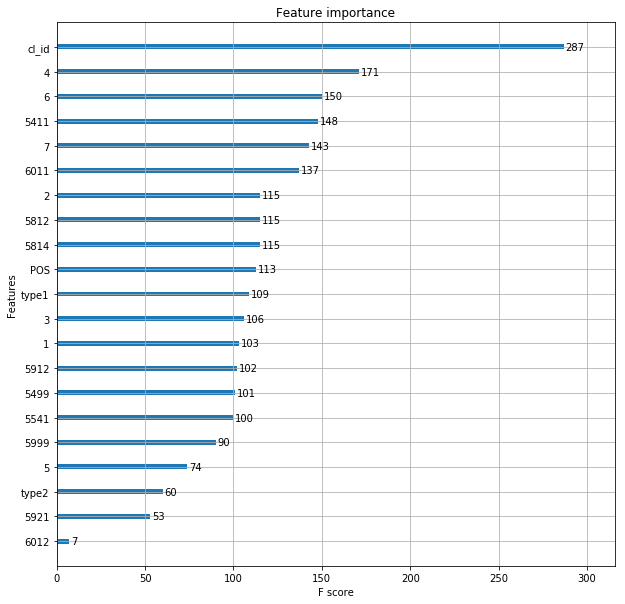

In [74]:
# построим граик важности признаков
xgboost.plot_importance(booster=xgb)

In [ ]:
## можем сделать вывод, что во многом вернется ли клиент зависит от самого клиента, 
## еще можно сказать, то наш идеальный клиент делает покупки в четверг, субботу и воскресение,
## при этом в основном в продовольственных магазинах, либо снимает в эти дни деньги, либо кушает в фастфудах и ресторанах, 
## оплачивая через POS-канал и первое взаимодействие с банком у него произошло через канал 1, то этот клиент с большей
## вероятностью вернется вновь.
## на удивление канал привлечения 2 с 37% транзакций и 89% вернувшимися клиентами оказался наименее значим..